# Exercise

## 1.Efficient frontier

In [1]:
import pandas as pd
import quandl 
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as solver
import datetime as dt
from functools import reduce
import seaborn as sns

In [2]:
#Download data from free financial data website using API
quandl.ApiConfig.api_key = 'XXXXXXXXXXXFe9A'
selected = ['CNP', 'F', 'NOW', 'COKE', 'WMT', 'GE', 'TSLA', 'SPLK', 'WDAY', 'AAPL', 'MSFT']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2018-1-1', 'lte': '2018-12-31' }, paginate=True)

In [3]:
#Transform the table - Pivot table
clean = data.set_index('date')
table = clean.pivot(columns='ticker')
table.head()

adj_close                                                     \
ticker          AAPL    CNP    COKE      F     GE   MSFT     NOW   SPLK   
date                                                                      
2018-01-02    172.26  28.02  211.28  12.66  17.98  85.95  131.73  86.63   
2018-01-03    172.23  27.96  209.00  12.76  18.15  86.35  132.91  88.16   
2018-01-04    173.03  27.99  205.51  12.98  18.53  87.11  133.85  87.95   
2018-01-05    175.00  27.87  202.00  13.20  18.54  88.19  135.01  87.88   
2018-01-08    174.35  28.04  208.95  13.15  18.28  88.28  135.30  89.98   

                                    
ticker        TSLA    WDAY     WMT  
date                                
2018-01-02  320.53  103.40   98.59  
2018-01-03  317.25  105.17   99.45  
2018-01-04  314.62  109.25   99.54  
2018-01-05  316.58  109.32  100.13  
2018-01-08  336.41  109.94  101.61

In [4]:
#calculate the log return
returns = np.log(table / table.shift(1))
#get the mean return and covariance matrix of each security from the DataFrame object and annualize.    
returns_annual = returns.mean() * 252
cov_annual = returns.cov() * 252

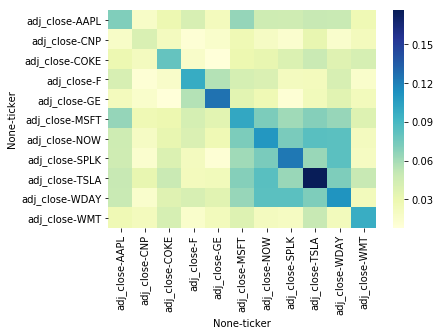

In [8]:
ax = sns.heatmap(cov_annual,cmap="YlGnBu")

In [55]:
# empty lists to store returns, volatility and weight of imiginary portfolios
port_return = []
port_volatility = []
sharpe_ratio = []
stock_weight = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 500000

#set seed 
np.random.seed(123)

# populate the empty lists with each portfolios returns,risk and weight
for single_portfolio in range(num_portfolios):
    weight = np.random.random(num_assets)
    weight /= np.sum(weight)
    returns = np.dot(weight, returns_annual)
    volatility = return np.sqrt(np.dot(weight.T, np.dot(cov_annual, weight))) 
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_return.append(returns)
    port_volatility.append(volatility)
    stock_weight.append(weight)




In [56]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_return,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

In [57]:
# dict to dataframe
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weight]
df = pd.DataFrame(portfolio)

#Create a list to reorder columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# rename columns
df = df[column_order]
print(df.head())

    Returns  Volatility  Sharpe Ratio  CNP Weight  F Weight  NOW Weight  \
0 -0.059835    0.220855     -0.270926    0.120389  0.049461    0.039213   
1 -0.216324    0.208889     -1.035590    0.138379  0.083244    0.011327   
2 -0.145744    0.198777     -0.733206    0.149302  0.125925    0.148887   
3 -0.152241    0.211896     -0.718471    0.090266  0.077860    0.057095   
4 -0.200823    0.215968     -0.929873    0.140735  0.040687    0.078471   

   COKE Weight  WMT Weight  GE Weight  TSLA Weight  SPLK Weight  WDAY Weight  \
0     0.095298    0.124364   0.073136     0.169531     0.118377     0.083132   
1     0.075552    0.140077   0.034638     0.033302     0.100892     0.100945   
2     0.066558    0.074560   0.047042     0.060531     0.130037     0.018982   
3     0.077955    0.163349   0.172632     0.091757     0.114085     0.021140   
4     0.160108    0.084392   0.099567     0.019597     0.134242     0.097969   

   AAPL Weight  MSFT Weight  
0     0.067780     0.059320  
1     0.

In [58]:
#max sharpe ration
print("Max sharpe ratio is {}".format(df['Sharpe Ratio'].max()))
max_sharpe_idx = df['Sharpe Ratio'].idxmax()
max_sharpe_return = df['Returns'][max_sharpe_idx]
max_sharpe_volatility = df['Volatility'][max_sharpe_idx]
print("Return of the portfolio with max sharpe ratio {}".format(max_sharpe_return))
print("Volatility of the portfolio with max sharpe ratio {}".format(max_sharpe_volatility))
print("---------------------")
global_min_idx = df["Volatility"].idxmin()
global_min_vol = df['Volatility'].min()
global_min_return = df['Returns'][global_min_idx]
print("Return of Global minimum variance point: {}".format(global_min_return))
print("Volatility of Global minimum variance point: {}".format(global_min_vol))

Max sharpe ratio is 1.964405674284112
Return of the portfolio with max sharpe ratio 0.5259333120599461
Volatility of the portfolio with max sharpe ratio 0.26773151744820317
---------------------
Return of Global minimum variance point: -0.2988084345625344
Volatility of Global minimum variance point: 0.1796122496635866


In [65]:
def minimize_vol(weight):
    return np.sqrt(np.dot(weight.T, np.dot(cov_annual, weight))) 

x0 = np.array([1.0 / num_assets for x in range(num_assets)])  
bounds = tuple((0, 1) for x in range(num_assets))  
given_r = np.arange(global_min_return, .45, .01)  
risk = []  
for i in given_r:  
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: sum(x * returns_annual) - i}]
    outcome = solver.minimize(minimize_vol, x0=x0,method='SLSQP', constraints=constraints, bounds=bounds)  
    risk.append(outcome.fun)  
#plt.plot(risk, given_r, 'r-x')  

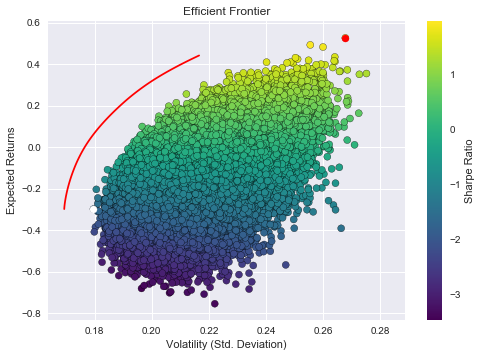

In [66]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn')
plt.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', data = df,
                cmap='viridis', edgecolors='black')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.plot(risk, given_r, 'r-x')  
plt.scatter(max_sharpe_volatility,max_sharpe_return, c='red', s=50)
plt.scatter(global_min_vol,global_min_return, c='white', s=50)
plt.show()